In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LEAR

In [2]:
df = pd.read_csv(r"Data\EPFToolbox\BE.csv")

In [3]:
df['Date'] = pd.to_datetime(df.Date)

In [4]:
df.index = df.Date

In [5]:
df = df.drop('Date', axis = 1)

In [6]:
df.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [7]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [9]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [10]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [11]:
forecast_dates = forecast.index

In [12]:
from epftoolbox.models import LEAR

In [13]:
calibration_window = 2*364

In [14]:
model = LEAR(calibration_window=calibration_window)

In [15]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 16.44%  |  MAE: 6.714
2015-01-02 - sMAPE: 14.91%  |  MAE: 5.964
2015-01-03 - sMAPE: 12.79%  |  MAE: 5.222
2015-01-04 - sMAPE: 11.95%  |  MAE: 4.794
2015-01-05 - sMAPE: 11.05%  |  MAE: 4.566
2015-01-06 - sMAPE: 11.00%  |  MAE: 4.653
2015-01-07 - sMAPE: 10.19%  |  MAE: 4.353
2015-01-08 - sMAPE: 9.71%  |  MAE: 4.142
2015-01-09 - sMAPE: 10.39%  |  MAE: 4.365
2015-01-10 - sMAPE: 10.77%  |  MAE: 4.408
2015-01-11 - sMAPE: 11.10%  |  MAE: 4.396
2015-01-12 - sMAPE: 11.07%  |  MAE: 4.387
2015-01-13 - sMAPE: 10.96%  |  MAE: 4.356
2015-01-14 - sMAPE: 10.65%  |  MAE: 4.237
2015-01-15 - sMAPE: 10.73%  |  MAE: 4.282
2015-01-16 - sMAPE: 10.36%  |  MAE: 4.132
2015-01-17 - sMAPE: 10.28%  |  MAE: 4.098
2015-01-18 - sMAPE: 10.14%  |  MAE: 4.033
2015-01-19 - sMAPE: 9.84%  |  MAE: 3.922
2015-01-20 - sMAPE: 9.57%  |  MAE: 3.825
2015-01-21 - sMAPE: 9.51%  |  MAE: 3.822
2015-01-22 - sMAPE: 9.36%  |  MAE: 3.787
2015-01-23 - sMAPE: 9.22%  |  MAE: 3.753
2015-01-24 - sMAPE: 9.21%  |  MAE: 3.759

2015-07-17 - sMAPE: 14.28%  |  MAE: 6.196
2015-07-18 - sMAPE: 14.24%  |  MAE: 6.181
2015-07-19 - sMAPE: 14.24%  |  MAE: 6.175
2015-07-20 - sMAPE: 14.22%  |  MAE: 6.165
2015-07-21 - sMAPE: 14.20%  |  MAE: 6.159
2015-07-22 - sMAPE: 14.15%  |  MAE: 6.138
2015-07-23 - sMAPE: 14.10%  |  MAE: 6.122
2015-07-24 - sMAPE: 14.06%  |  MAE: 6.105
2015-07-25 - sMAPE: 14.18%  |  MAE: 6.131
2015-07-26 - sMAPE: 14.19%  |  MAE: 6.123
2015-07-27 - sMAPE: 14.23%  |  MAE: 6.127
2015-07-28 - sMAPE: 14.33%  |  MAE: 6.149
2015-07-29 - sMAPE: 14.36%  |  MAE: 6.156
2015-07-30 - sMAPE: 14.37%  |  MAE: 6.155
2015-07-31 - sMAPE: 14.38%  |  MAE: 6.152
2015-08-01 - sMAPE: 14.37%  |  MAE: 6.143
2015-08-02 - sMAPE: 14.43%  |  MAE: 6.154
2015-08-03 - sMAPE: 14.45%  |  MAE: 6.161
2015-08-04 - sMAPE: 14.43%  |  MAE: 6.149
2015-08-05 - sMAPE: 14.41%  |  MAE: 6.139
2015-08-06 - sMAPE: 14.38%  |  MAE: 6.125
2015-08-07 - sMAPE: 14.34%  |  MAE: 6.108
2015-08-08 - sMAPE: 14.36%  |  MAE: 6.106
2015-08-09 - sMAPE: 14.33%  |  MAE

2016-01-29 - sMAPE: 15.33%  |  MAE: 7.027
2016-01-30 - sMAPE: 15.36%  |  MAE: 7.024
2016-01-31 - sMAPE: 15.50%  |  MAE: 7.030
2016-02-01 - sMAPE: 15.51%  |  MAE: 7.024
2016-02-02 - sMAPE: 15.55%  |  MAE: 7.023
2016-02-03 - sMAPE: 15.58%  |  MAE: 7.024
2016-02-04 - sMAPE: 15.60%  |  MAE: 7.023
2016-02-05 - sMAPE: 15.59%  |  MAE: 7.015
2016-02-06 - sMAPE: 15.62%  |  MAE: 7.012
2016-02-07 - sMAPE: 15.77%  |  MAE: 7.018
2016-02-08 - sMAPE: 15.82%  |  MAE: 7.018
2016-02-09 - sMAPE: 15.83%  |  MAE: 7.015
2016-02-10 - sMAPE: 15.83%  |  MAE: 7.008
2016-02-11 - sMAPE: 15.81%  |  MAE: 6.998
2016-02-12 - sMAPE: 15.81%  |  MAE: 6.994
2016-02-13 - sMAPE: 15.81%  |  MAE: 6.988
2016-02-14 - sMAPE: 15.86%  |  MAE: 6.984
2016-02-15 - sMAPE: 15.87%  |  MAE: 6.979
2016-02-16 - sMAPE: 15.85%  |  MAE: 6.969
2016-02-17 - sMAPE: 15.83%  |  MAE: 6.959
2016-02-18 - sMAPE: 15.81%  |  MAE: 6.948
2016-02-19 - sMAPE: 15.81%  |  MAE: 6.945
2016-02-20 - sMAPE: 15.85%  |  MAE: 6.945
2016-02-21 - sMAPE: 16.09%  |  MAE

2016-08-12 - sMAPE: 15.81%  |  MAE: 5.953
2016-08-13 - sMAPE: 15.81%  |  MAE: 5.950
2016-08-14 - sMAPE: 15.80%  |  MAE: 5.943
2016-08-15 - sMAPE: 15.79%  |  MAE: 5.937
2016-08-16 - sMAPE: 15.78%  |  MAE: 5.931
2016-08-17 - sMAPE: 15.77%  |  MAE: 5.927
2016-08-18 - sMAPE: 15.76%  |  MAE: 5.920
2016-08-19 - sMAPE: 15.74%  |  MAE: 5.915
2016-08-20 - sMAPE: 15.73%  |  MAE: 5.909
2016-08-21 - sMAPE: 15.77%  |  MAE: 5.908
2016-08-22 - sMAPE: 15.76%  |  MAE: 5.903
2016-08-23 - sMAPE: 15.74%  |  MAE: 5.896
2016-08-24 - sMAPE: 15.73%  |  MAE: 5.891
2016-08-25 - sMAPE: 15.71%  |  MAE: 5.885
2016-08-26 - sMAPE: 15.70%  |  MAE: 5.879
2016-08-27 - sMAPE: 15.69%  |  MAE: 5.874
2016-08-28 - sMAPE: 15.68%  |  MAE: 5.868
2016-08-29 - sMAPE: 15.69%  |  MAE: 5.871
2016-08-30 - sMAPE: 15.69%  |  MAE: 5.871
2016-08-31 - sMAPE: 15.69%  |  MAE: 5.869
2016-09-01 - sMAPE: 15.68%  |  MAE: 5.864
2016-09-02 - sMAPE: 15.68%  |  MAE: 5.864
2016-09-03 - sMAPE: 15.67%  |  MAE: 5.859
2016-09-04 - sMAPE: 15.66%  |  MAE

In [16]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.911084,39.472242,37.854197,33.924181,31.665809,32.276355,34.607038,40.658493,41.648884,46.1267,...,41.878349,39.807129,40.929574,50.591804,56.924056,54.507615,49.787255,45.238413,48.076054,45.687513
2015-01-02,43.847344,40.099827,38.925907,35.775365,33.835295,34.035482,38.552879,45.073899,47.143734,50.810787,...,45.64874,42.960138,44.075394,51.993968,57.59086,56.040048,51.269291,47.109681,49.295307,47.431885
2015-01-03,41.093025,36.922978,35.219985,31.379451,30.250698,30.570372,35.20857,40.03762,44.47231,49.492253,...,43.2565,41.456286,43.99706,50.899759,58.833489,51.866404,48.28436,45.389504,47.886108,45.591972
2015-01-04,39.07902,35.255318,34.069935,32.214628,30.124418,29.165476,28.178791,28.627278,33.84011,38.277528,...,40.313583,38.191459,41.979448,50.774358,57.906584,53.463965,50.016197,44.994138,46.706886,44.415916
2015-01-05,36.282053,33.760799,31.910498,29.375398,29.398893,31.667319,41.715586,53.420264,53.68759,55.013472,...,50.96417,50.190661,49.825013,62.728174,67.900327,62.631142,52.528572,46.974029,48.429996,46.322427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,38.61519,33.265811,31.310127,26.654592,26.176234,28.856929,38.443,46.396004,49.498572,53.220026,...,48.774503,46.552738,49.433891,57.88794,60.707451,57.779324,50.439245,43.575183,46.157955,44.803166
2016-12-28,44.605382,37.918592,35.958053,30.273846,29.892886,32.26768,42.162131,52.802766,55.893674,57.575715,...,52.035464,52.321205,54.749802,64.517703,69.385183,64.635652,53.342396,44.535448,47.538598,47.385632
2016-12-29,40.102631,35.546827,34.365534,31.024035,30.857164,34.437479,43.986316,55.363787,58.470714,59.544029,...,54.379265,54.298635,58.14791,67.518247,73.277276,65.972877,56.348978,48.452676,47.900359,47.064083


In [17]:
forecast.to_csv("Resultados/be_epftoolbox_final_2_anos_ventana.csv")

In [18]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [19]:
forecast_dates = forecast.index

In [20]:
calibration_window = 1*364

In [21]:
model = LEAR(calibration_window=calibration_window)

In [22]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 17.15%  |  MAE: 6.885
2015-01-02 - sMAPE: 12.98%  |  MAE: 5.062
2015-01-03 - sMAPE: 11.19%  |  MAE: 4.408
2015-01-04 - sMAPE: 11.16%  |  MAE: 4.319
2015-01-05 - sMAPE: 10.13%  |  MAE: 3.996
2015-01-06 - sMAPE: 9.89%  |  MAE: 3.953
2015-01-07 - sMAPE: 9.23%  |  MAE: 3.726
2015-01-08 - sMAPE: 8.87%  |  MAE: 3.596
2015-01-09 - sMAPE: 9.43%  |  MAE: 3.799
2015-01-10 - sMAPE: 10.02%  |  MAE: 3.956
2015-01-11 - sMAPE: 10.29%  |  MAE: 3.991
2015-01-12 - sMAPE: 10.18%  |  MAE: 3.938
2015-01-13 - sMAPE: 10.15%  |  MAE: 3.949
2015-01-14 - sMAPE: 9.76%  |  MAE: 3.811
2015-01-15 - sMAPE: 10.08%  |  MAE: 3.958
2015-01-16 - sMAPE: 9.83%  |  MAE: 3.864
2015-01-17 - sMAPE: 9.71%  |  MAE: 3.816
2015-01-18 - sMAPE: 9.55%  |  MAE: 3.750
2015-01-19 - sMAPE: 9.44%  |  MAE: 3.727
2015-01-20 - sMAPE: 9.37%  |  MAE: 3.729
2015-01-21 - sMAPE: 9.43%  |  MAE: 3.778
2015-01-22 - sMAPE: 9.43%  |  MAE: 3.815
2015-01-23 - sMAPE: 9.24%  |  MAE: 3.753
2015-01-24 - sMAPE: 9.23%  |  MAE: 3.750
2015-0

2015-07-17 - sMAPE: 14.89%  |  MAE: 6.437
2015-07-18 - sMAPE: 14.87%  |  MAE: 6.426
2015-07-19 - sMAPE: 14.89%  |  MAE: 6.426
2015-07-20 - sMAPE: 14.86%  |  MAE: 6.416
2015-07-21 - sMAPE: 14.84%  |  MAE: 6.409
2015-07-22 - sMAPE: 14.79%  |  MAE: 6.386
2015-07-23 - sMAPE: 14.74%  |  MAE: 6.369
2015-07-24 - sMAPE: 14.70%  |  MAE: 6.353
2015-07-25 - sMAPE: 14.83%  |  MAE: 6.385
2015-07-26 - sMAPE: 14.87%  |  MAE: 6.383
2015-07-27 - sMAPE: 14.91%  |  MAE: 6.388
2015-07-28 - sMAPE: 15.02%  |  MAE: 6.416
2015-07-29 - sMAPE: 15.07%  |  MAE: 6.426
2015-07-30 - sMAPE: 15.10%  |  MAE: 6.429
2015-07-31 - sMAPE: 15.10%  |  MAE: 6.428
2015-08-01 - sMAPE: 15.12%  |  MAE: 6.429
2015-08-02 - sMAPE: 15.18%  |  MAE: 6.440
2015-08-03 - sMAPE: 15.20%  |  MAE: 6.444
2015-08-04 - sMAPE: 15.17%  |  MAE: 6.430
2015-08-05 - sMAPE: 15.15%  |  MAE: 6.421
2015-08-06 - sMAPE: 15.13%  |  MAE: 6.408
2015-08-07 - sMAPE: 15.09%  |  MAE: 6.391
2015-08-08 - sMAPE: 15.12%  |  MAE: 6.395
2015-08-09 - sMAPE: 15.11%  |  MAE

2016-01-29 - sMAPE: 16.07%  |  MAE: 7.291
2016-01-30 - sMAPE: 16.10%  |  MAE: 7.289
2016-01-31 - sMAPE: 16.22%  |  MAE: 7.295
2016-02-01 - sMAPE: 16.23%  |  MAE: 7.288
2016-02-02 - sMAPE: 16.29%  |  MAE: 7.290
2016-02-03 - sMAPE: 16.32%  |  MAE: 7.293
2016-02-04 - sMAPE: 16.33%  |  MAE: 7.292
2016-02-05 - sMAPE: 16.33%  |  MAE: 7.285
2016-02-06 - sMAPE: 16.35%  |  MAE: 7.279
2016-02-07 - sMAPE: 16.45%  |  MAE: 7.277
2016-02-08 - sMAPE: 16.50%  |  MAE: 7.277
2016-02-09 - sMAPE: 16.51%  |  MAE: 7.274
2016-02-10 - sMAPE: 16.51%  |  MAE: 7.268
2016-02-11 - sMAPE: 16.49%  |  MAE: 7.258
2016-02-12 - sMAPE: 16.49%  |  MAE: 7.254
2016-02-13 - sMAPE: 16.49%  |  MAE: 7.245
2016-02-14 - sMAPE: 16.51%  |  MAE: 7.238
2016-02-15 - sMAPE: 16.51%  |  MAE: 7.231
2016-02-16 - sMAPE: 16.50%  |  MAE: 7.223
2016-02-17 - sMAPE: 16.48%  |  MAE: 7.213
2016-02-18 - sMAPE: 16.46%  |  MAE: 7.200
2016-02-19 - sMAPE: 16.46%  |  MAE: 7.197
2016-02-20 - sMAPE: 16.49%  |  MAE: 7.195
2016-02-21 - sMAPE: 16.73%  |  MAE

2016-08-12 - sMAPE: 16.26%  |  MAE: 6.158
2016-08-13 - sMAPE: 16.27%  |  MAE: 6.155
2016-08-14 - sMAPE: 16.26%  |  MAE: 6.149
2016-08-15 - sMAPE: 16.25%  |  MAE: 6.142
2016-08-16 - sMAPE: 16.23%  |  MAE: 6.135
2016-08-17 - sMAPE: 16.22%  |  MAE: 6.130
2016-08-18 - sMAPE: 16.20%  |  MAE: 6.123
2016-08-19 - sMAPE: 16.19%  |  MAE: 6.117
2016-08-20 - sMAPE: 16.18%  |  MAE: 6.112
2016-08-21 - sMAPE: 16.23%  |  MAE: 6.114
2016-08-22 - sMAPE: 16.22%  |  MAE: 6.109
2016-08-23 - sMAPE: 16.21%  |  MAE: 6.103
2016-08-24 - sMAPE: 16.19%  |  MAE: 6.098
2016-08-25 - sMAPE: 16.18%  |  MAE: 6.093
2016-08-26 - sMAPE: 16.17%  |  MAE: 6.087
2016-08-27 - sMAPE: 16.16%  |  MAE: 6.082
2016-08-28 - sMAPE: 16.15%  |  MAE: 6.077
2016-08-29 - sMAPE: 16.17%  |  MAE: 6.083
2016-08-30 - sMAPE: 16.17%  |  MAE: 6.082
2016-08-31 - sMAPE: 16.17%  |  MAE: 6.080
2016-09-01 - sMAPE: 16.15%  |  MAE: 6.074
2016-09-02 - sMAPE: 16.16%  |  MAE: 6.074
2016-09-03 - sMAPE: 16.15%  |  MAE: 6.071
2016-09-04 - sMAPE: 16.16%  |  MAE

In [23]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,42.208074,36.571561,34.936731,31.557474,30.169694,31.268675,33.816689,39.568297,43.293146,46.092527,...,40.713446,39.205578,39.985474,50.387101,55.168489,52.232859,49.627918,44.108787,45.929187,42.061125
2015-01-02,41.60032,36.588412,35.347053,32.299446,31.543597,32.324992,36.744303,44.58413,46.284204,47.379219,...,43.617472,41.006215,41.114722,49.875683,56.238961,54.694681,48.625642,44.739514,46.585369,42.717206
2015-01-03,38.955785,36.369611,33.242136,30.039677,28.636383,29.318284,34.325572,41.055725,43.425176,46.574026,...,41.067854,39.889079,40.566659,50.612695,57.688759,51.701594,48.11574,42.783889,45.015214,42.247769
2015-01-04,36.790398,33.692227,32.984037,30.826143,29.581187,30.527262,32.573086,33.074413,40.148347,44.044341,...,40.626849,38.822656,40.221347,48.6565,55.93652,51.928443,49.584236,44.732277,46.416583,42.422424
2015-01-05,36.287186,33.024731,30.941263,28.891929,28.090039,29.896065,38.626453,47.745554,49.02764,49.702017,...,46.62153,45.92784,47.464595,57.304669,59.742761,58.533038,51.0132,43.087229,45.080951,42.255989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,35.325331,29.110404,27.722059,24.895026,24.408302,28.684656,38.519156,45.763153,51.607885,53.075742,...,52.034492,50.562736,53.679412,62.8126,62.789627,58.152152,50.402503,42.403501,44.185024,42.188644
2016-12-28,40.031528,33.683713,32.606213,30.7638,29.825472,32.319601,39.963187,51.627012,56.252564,57.996439,...,49.641842,50.634415,52.908426,61.376053,71.839687,61.761898,52.338766,42.749571,45.258821,46.326773
2016-12-29,38.564231,34.761322,33.453459,31.038168,30.627908,34.747225,42.572265,58.3984,61.816437,60.858565,...,57.431887,56.022042,59.390285,66.931373,72.523633,66.096773,56.780753,47.620664,46.666174,45.945434


In [24]:
forecast.to_csv("Resultados/be_epftoolbox_final_1_ano_ventana.csv")

In [25]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [26]:
forecast_dates = forecast.index

In [27]:
calibration_window = 182

In [28]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 18.17%  |  MAE: 7.587
2015-01-02 - sMAPE: 15.44%  |  MAE: 6.300
2015-01-03 - sMAPE: 12.88%  |  MAE: 5.252
2015-01-04 - sMAPE: 12.21%  |  MAE: 4.894
2015-01-05 - sMAPE: 11.05%  |  MAE: 4.487
2015-01-06 - sMAPE: 10.59%  |  MAE: 4.357
2015-01-07 - sMAPE: 9.81%  |  MAE: 4.075
2015-01-08 - sMAPE: 9.40%  |  MAE: 3.909
2015-01-09 - sMAPE: 10.25%  |  MAE: 4.206
2015-01-10 - sMAPE: 10.67%  |  MAE: 4.281
2015-01-11 - sMAPE: 11.32%  |  MAE: 4.450
2015-01-12 - sMAPE: 11.24%  |  MAE: 4.403
2015-01-13 - sMAPE: 11.09%  |  MAE: 4.355
2015-01-14 - sMAPE: 10.82%  |  MAE: 4.271
2015-01-15 - sMAPE: 10.97%  |  MAE: 4.334
2015-01-16 - sMAPE: 10.63%  |  MAE: 4.205
2015-01-17 - sMAPE: 10.60%  |  MAE: 4.197
2015-01-18 - sMAPE: 10.26%  |  MAE: 4.064
2015-01-19 - sMAPE: 10.08%  |  MAE: 4.016
2015-01-20 - sMAPE: 9.95%  |  MAE: 3.996
2015-01-21 - sMAPE: 9.91%  |  MAE: 4.008
2015-01-22 - sMAPE: 9.79%  |  MAE: 3.987
2015-01-23 - sMAPE: 9.63%  |  MAE: 3.944
2015-01-24 - sMAPE: 9.65%  |  MAE: 3.966

2015-07-17 - sMAPE: 16.03%  |  MAE: 6.889
2015-07-18 - sMAPE: 15.99%  |  MAE: 6.874
2015-07-19 - sMAPE: 16.00%  |  MAE: 6.870
2015-07-20 - sMAPE: 15.97%  |  MAE: 6.858
2015-07-21 - sMAPE: 15.94%  |  MAE: 6.850
2015-07-22 - sMAPE: 15.90%  |  MAE: 6.831
2015-07-23 - sMAPE: 15.85%  |  MAE: 6.812
2015-07-24 - sMAPE: 15.80%  |  MAE: 6.792
2015-07-25 - sMAPE: 15.91%  |  MAE: 6.814
2015-07-26 - sMAPE: 15.93%  |  MAE: 6.809
2015-07-27 - sMAPE: 15.99%  |  MAE: 6.820
2015-07-28 - sMAPE: 16.10%  |  MAE: 6.849
2015-07-29 - sMAPE: 16.15%  |  MAE: 6.857
2015-07-30 - sMAPE: 16.17%  |  MAE: 6.859
2015-07-31 - sMAPE: 16.16%  |  MAE: 6.851
2015-08-01 - sMAPE: 16.18%  |  MAE: 6.851
2015-08-02 - sMAPE: 16.23%  |  MAE: 6.861
2015-08-03 - sMAPE: 16.25%  |  MAE: 6.864
2015-08-04 - sMAPE: 16.22%  |  MAE: 6.850
2015-08-05 - sMAPE: 16.19%  |  MAE: 6.835
2015-08-06 - sMAPE: 16.16%  |  MAE: 6.819
2015-08-07 - sMAPE: 16.10%  |  MAE: 6.797
2015-08-08 - sMAPE: 16.10%  |  MAE: 6.789
2015-08-09 - sMAPE: 16.09%  |  MAE

2016-01-29 - sMAPE: 17.11%  |  MAE: 7.716
2016-01-30 - sMAPE: 17.15%  |  MAE: 7.718
2016-01-31 - sMAPE: 17.23%  |  MAE: 7.722
2016-02-01 - sMAPE: 17.23%  |  MAE: 7.713
2016-02-02 - sMAPE: 17.28%  |  MAE: 7.713
2016-02-03 - sMAPE: 17.29%  |  MAE: 7.710
2016-02-04 - sMAPE: 17.29%  |  MAE: 7.704
2016-02-05 - sMAPE: 17.29%  |  MAE: 7.697
2016-02-06 - sMAPE: 17.34%  |  MAE: 7.700
2016-02-07 - sMAPE: 17.41%  |  MAE: 7.698
2016-02-08 - sMAPE: 17.43%  |  MAE: 7.687
2016-02-09 - sMAPE: 17.42%  |  MAE: 7.679
2016-02-10 - sMAPE: 17.41%  |  MAE: 7.669
2016-02-11 - sMAPE: 17.39%  |  MAE: 7.657
2016-02-12 - sMAPE: 17.39%  |  MAE: 7.652
2016-02-13 - sMAPE: 17.40%  |  MAE: 7.649
2016-02-14 - sMAPE: 17.47%  |  MAE: 7.651
2016-02-15 - sMAPE: 17.45%  |  MAE: 7.640
2016-02-16 - sMAPE: 17.44%  |  MAE: 7.630
2016-02-17 - sMAPE: 17.43%  |  MAE: 7.620
2016-02-18 - sMAPE: 17.40%  |  MAE: 7.607
2016-02-19 - sMAPE: 17.40%  |  MAE: 7.603
2016-02-20 - sMAPE: 17.45%  |  MAE: 7.609
2016-02-21 - sMAPE: 17.58%  |  MAE

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/be_epftoolbox_final_6_meses_ventana.csv")

# Estandarización móvil

In [8]:
df = pd.read_csv("Data\EPFToolbox\BE.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [9]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [10]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [11]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.54,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.55,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.71,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.58,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.32,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,40.84,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,40.10,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,36.00,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,35.00,65886.0,67823.0,2016-12-31,22


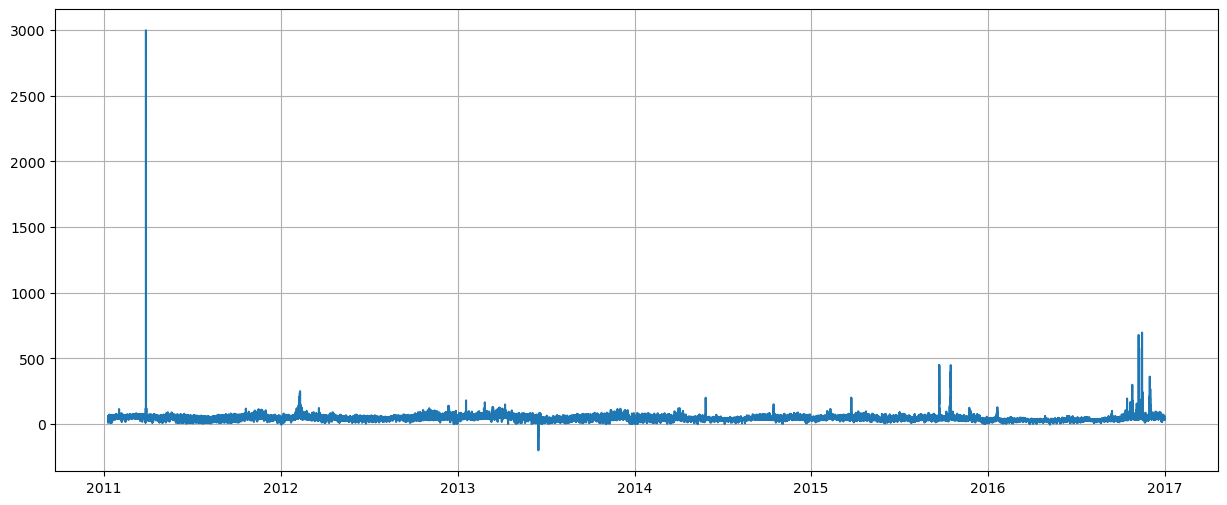

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

Se añaden variables auxiliares

In [13]:
# df['Price_24'] = df.Price.shift(24)
# df['Price_48'] = df.Price.shift(48)
# df['Price_72'] = df.Price.shift(72)
# df['Price_168'] = df.Price.shift(168)

In [14]:
# names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# for i, x in enumerate(names):
#     df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [15]:
# for hora in range(24):
#     df['Price_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
#         df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [16]:
# for col in ['Price_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [17]:
# for hora in range(24):
#     df['Exogenous 1_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [18]:
# for hora in range(24):
#     df['Exogenous 2_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [19]:
# for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)
# for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [20]:
# list(df.columns)

In [21]:
columnas = ['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
#  'Price_24',
#  'Price_48',
#  'Price_72',
#  'Price_168',
#  'Price_hora_0',
#  'Price_hora_1',
#  'Price_hora_2',
#  'Price_hora_3',
#  'Price_hora_4',
#  'Price_hora_5',
#  'Price_hora_6',
#  'Price_hora_7',
#  'Price_hora_8',
#  'Price_hora_9',
#  'Price_hora_10',
#  'Price_hora_11',
#  'Price_hora_12',
#  'Price_hora_13',
#  'Price_hora_14',
#  'Price_hora_15',
#  'Price_hora_16',
#  'Price_hora_17',
#  'Price_hora_18',
#  'Price_hora_19',
#  'Price_hora_20',
#  'Price_hora_21',
#  'Price_hora_22',
#  'Price_hora_23',
#  'Price_hora_0_24',
#  'Price_hora_0_48',
#  'Price_hora_0_72',
#  'Price_hora_0_168',
#  'Price_hora_1_24',
#  'Price_hora_1_48',
#  'Price_hora_1_72',
#  'Price_hora_1_168',
#  'Price_hora_2_24',
#  'Price_hora_2_48',
#  'Price_hora_2_72',
#  'Price_hora_2_168',
#  'Price_hora_3_24',
#  'Price_hora_3_48',
#  'Price_hora_3_72',
#  'Price_hora_3_168',
#  'Price_hora_4_24',
#  'Price_hora_4_48',
#  'Price_hora_4_72',
#  'Price_hora_4_168',
#  'Price_hora_5_24',
#  'Price_hora_5_48',
#  'Price_hora_5_72',
#  'Price_hora_5_168',
#  'Price_hora_6_24',
#  'Price_hora_6_48',
#  'Price_hora_6_72',
#  'Price_hora_6_168',
#  'Price_hora_7_24',
#  'Price_hora_7_48',
#  'Price_hora_7_72',
#  'Price_hora_7_168',
#  'Price_hora_8_24',
#  'Price_hora_8_48',
#  'Price_hora_8_72',
#  'Price_hora_8_168',
#  'Price_hora_9_24',
#  'Price_hora_9_48',
#  'Price_hora_9_72',
#  'Price_hora_9_168',
#  'Price_hora_10_24',
#  'Price_hora_10_48',
#  'Price_hora_10_72',
#  'Price_hora_10_168',
#  'Price_hora_11_24',
#  'Price_hora_11_48',
#  'Price_hora_11_72',
#  'Price_hora_11_168',
#  'Price_hora_12_24',
#  'Price_hora_12_48',
#  'Price_hora_12_72',
#  'Price_hora_12_168',
#  'Price_hora_13_24',
#  'Price_hora_13_48',
#  'Price_hora_13_72',
#  'Price_hora_13_168',
#  'Price_hora_14_24',
#  'Price_hora_14_48',
#  'Price_hora_14_72',
#  'Price_hora_14_168',
#  'Price_hora_15_24',
#  'Price_hora_15_48',
#  'Price_hora_15_72',
#  'Price_hora_15_168',
#  'Price_hora_16_24',
#  'Price_hora_16_48',
#  'Price_hora_16_72',
#  'Price_hora_16_168',
#  'Price_hora_17_24',
#  'Price_hora_17_48',
#  'Price_hora_17_72',
#  'Price_hora_17_168',
#  'Price_hora_18_24',
#  'Price_hora_18_48',
#  'Price_hora_18_72',
#  'Price_hora_18_168',
#  'Price_hora_19_24',
#  'Price_hora_19_48',
#  'Price_hora_19_72',
#  'Price_hora_19_168',
#  'Price_hora_20_24',
#  'Price_hora_20_48',
#  'Price_hora_20_72',
#  'Price_hora_20_168',
#  'Price_hora_21_24',
#  'Price_hora_21_48',
#  'Price_hora_21_72',
#  'Price_hora_21_168',
#  'Price_hora_22_24',
#  'Price_hora_22_48',
#  'Price_hora_22_72',
#  'Price_hora_22_168',
#  'Price_hora_23_24',
#  'Price_hora_23_48',
#  'Price_hora_23_72',
#  'Price_hora_23_168',
#  'Exogenous 1_hora_0',
#  'Exogenous 1_hora_1',
#  'Exogenous 1_hora_2',
#  'Exogenous 1_hora_3',
#  'Exogenous 1_hora_4',
#  'Exogenous 1_hora_5',
#  'Exogenous 1_hora_6',
#  'Exogenous 1_hora_7',
#  'Exogenous 1_hora_8',
#  'Exogenous 1_hora_9',
#  'Exogenous 1_hora_10',
#  'Exogenous 1_hora_11',
#  'Exogenous 1_hora_12',
#  'Exogenous 1_hora_13',
#  'Exogenous 1_hora_14',
#  'Exogenous 1_hora_15',
#  'Exogenous 1_hora_16',
#  'Exogenous 1_hora_17',
#  'Exogenous 1_hora_18',
#  'Exogenous 1_hora_19',
#  'Exogenous 1_hora_20',
#  'Exogenous 1_hora_21',
#  'Exogenous 1_hora_22',
#  'Exogenous 1_hora_23',
#  'Exogenous 2_hora_0',
#  'Exogenous 2_hora_1',
#  'Exogenous 2_hora_2',
#  'Exogenous 2_hora_3',
#  'Exogenous 2_hora_4',
#  'Exogenous 2_hora_5',
#  'Exogenous 2_hora_6',
#  'Exogenous 2_hora_7',
#  'Exogenous 2_hora_8',
#  'Exogenous 2_hora_9',
#  'Exogenous 2_hora_10',
#  'Exogenous 2_hora_11',
#  'Exogenous 2_hora_12',
#  'Exogenous 2_hora_13',
#  'Exogenous 2_hora_14',
#  'Exogenous 2_hora_15',
#  'Exogenous 2_hora_16',
#  'Exogenous 2_hora_17',
#  'Exogenous 2_hora_18',
#  'Exogenous 2_hora_19',
#  'Exogenous 2_hora_20',
#  'Exogenous 2_hora_21',
#  'Exogenous 2_hora_22',
#  'Exogenous 2_hora_23',
#  'Exogenous 1_hora_0_24',
#  'Exogenous 1_hora_0_168',
#  'Exogenous 1_hora_1_24',
#  'Exogenous 1_hora_1_168',
#  'Exogenous 1_hora_2_24',
#  'Exogenous 1_hora_2_168',
#  'Exogenous 1_hora_3_24',
#  'Exogenous 1_hora_3_168',
#  'Exogenous 1_hora_4_24',
#  'Exogenous 1_hora_4_168',
#  'Exogenous 1_hora_5_24',
#  'Exogenous 1_hora_5_168',
#  'Exogenous 1_hora_6_24',
#  'Exogenous 1_hora_6_168',
#  'Exogenous 1_hora_7_24',
#  'Exogenous 1_hora_7_168',
#  'Exogenous 1_hora_8_24',
#  'Exogenous 1_hora_8_168',
#  'Exogenous 1_hora_9_24',
#  'Exogenous 1_hora_9_168',
#  'Exogenous 1_hora_10_24',
#  'Exogenous 1_hora_10_168',
#  'Exogenous 1_hora_11_24',
#  'Exogenous 1_hora_11_168',
#  'Exogenous 1_hora_12_24',
#  'Exogenous 1_hora_12_168',
#  'Exogenous 1_hora_13_24',
#  'Exogenous 1_hora_13_168',
#  'Exogenous 1_hora_14_24',
#  'Exogenous 1_hora_14_168',
#  'Exogenous 1_hora_15_24',
#  'Exogenous 1_hora_15_168',
#  'Exogenous 1_hora_16_24',
#  'Exogenous 1_hora_16_168',
#  'Exogenous 1_hora_17_24',
#  'Exogenous 1_hora_17_168',
#  'Exogenous 1_hora_18_24',
#  'Exogenous 1_hora_18_168',
#  'Exogenous 1_hora_19_24',
#  'Exogenous 1_hora_19_168',
#  'Exogenous 1_hora_20_24',
#  'Exogenous 1_hora_20_168',
#  'Exogenous 1_hora_21_24',
#  'Exogenous 1_hora_21_168',
#  'Exogenous 1_hora_22_24',
#  'Exogenous 1_hora_22_168',
#  'Exogenous 1_hora_23_24',
#  'Exogenous 1_hora_23_168',
#  'Exogenous 2_hora_0_24',
#  'Exogenous 2_hora_0_168',
#  'Exogenous 2_hora_1_24',
#  'Exogenous 2_hora_1_168',
#  'Exogenous 2_hora_2_24',
#  'Exogenous 2_hora_2_168',
#  'Exogenous 2_hora_3_24',
#  'Exogenous 2_hora_3_168',
#  'Exogenous 2_hora_4_24',
#  'Exogenous 2_hora_4_168',
#  'Exogenous 2_hora_5_24',
#  'Exogenous 2_hora_5_168',
#  'Exogenous 2_hora_6_24',
#  'Exogenous 2_hora_6_168',
#  'Exogenous 2_hora_7_24',
#  'Exogenous 2_hora_7_168',
#  'Exogenous 2_hora_8_24',
#  'Exogenous 2_hora_8_168',
#  'Exogenous 2_hora_9_24',
#  'Exogenous 2_hora_9_168',
#  'Exogenous 2_hora_10_24',
#  'Exogenous 2_hora_10_168',
#  'Exogenous 2_hora_11_24',
#  'Exogenous 2_hora_11_168',
#  'Exogenous 2_hora_12_24',
#  'Exogenous 2_hora_12_168',
#  'Exogenous 2_hora_13_24',
#  'Exogenous 2_hora_13_168',
#  'Exogenous 2_hora_14_24',
#  'Exogenous 2_hora_14_168',
#  'Exogenous 2_hora_15_24',
#  'Exogenous 2_hora_15_168',
#  'Exogenous 2_hora_16_24',
#  'Exogenous 2_hora_16_168',
#  'Exogenous 2_hora_17_24',
#  'Exogenous 2_hora_17_168',
#  'Exogenous 2_hora_18_24',
#  'Exogenous 2_hora_18_168',
#  'Exogenous 2_hora_19_24',
#  'Exogenous 2_hora_19_168',
#  'Exogenous 2_hora_20_24',
#  'Exogenous 2_hora_20_168',
#  'Exogenous 2_hora_21_24',
#  'Exogenous 2_hora_21_168',
#  'Exogenous 2_hora_22_24',
#  'Exogenous 2_hora_22_168',
#  'Exogenous 2_hora_23_24',
#  'Exogenous 2_hora_23_168'
           ]

# columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
#        'Saturday', 'Sunday']

In [22]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['scaler'].append(scaler)
                    dict_new_df['Price_real'].append(row[col])
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [23]:
dict_new_df = standard_movil(df[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 52416/52416 [27:48<00:00, 31.42it/s]


In [24]:
with open('dict_new_df_be_epftoolbox_final.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

# Estandarización móvil + LEAR

In [2]:
with open('dict_new_df_be_epftoolbox_final.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [3]:
df_nuevo = pd.DataFrame(dict_new_df)

In [4]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [5]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [6]:
df_scalers

,Date,scaler
0,2011-01-16 00:00:00,StandardScaler()
1,2011-01-16 01:00:00,StandardScaler()
2,2011-01-16 02:00:00,StandardScaler()
3,2011-01-16 03:00:00,StandardScaler()
4,2011-01-16 04:00:00,StandardScaler()
...,...,...
52243,2016-12-31 19:00:00,StandardScaler()
52244,2016-12-31 20:00:00,StandardScaler()
52245,2016-12-31 21:00:00,StandardScaler()
52246,2016-12-31 22:00:00,StandardScaler()


In [7]:
df_nuevo = df_nuevo[['Date', 'Price', 'Exogenous 1', 'Exogenous 2']]

In [8]:
df = df_nuevo

In [9]:
df.index = df.Date

In [10]:
df = df.drop(['Date'], axis = 1)

In [11]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [12]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [13]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [14]:
forecast_dates = forecast.index

In [15]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [16]:
calibration_window = 2*364

In [17]:
model = LEAR(calibration_window=calibration_window)

In [18]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [19]:
df_original = pd.read_csv(r"Data\EPFToolbox\BE.csv")

In [20]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [21]:
df_original.isna().sum()

Date                     0
 Prices                  0
 Generation forecast     0
 System load forecast    0
dtype: int64

In [22]:
df_original.index = df_original.Date

In [23]:
df_original = df_original.drop(['Date'], axis = 1)

In [24]:
df_original

,Prices,Generation forecast,System load forecast
Date,,,
2011-01-09 00:00:00,32.54,63065.0,63000.0
2011-01-09 01:00:00,21.55,62715.0,58800.0
2011-01-09 02:00:00,15.71,61952.0,58500.0
2011-01-09 03:00:00,10.58,59262.0,54300.0
2011-01-09 04:00:00,10.32,56883.0,51900.0
...,...,...,...
2016-12-31 19:00:00,40.84,70329.0,73957.0
2016-12-31 20:00:00,40.10,69121.0,72544.0
2016-12-31 21:00:00,36.00,66647.0,69451.0


In [25]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [26]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [27]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,42.44,39.94,42.44,53.10,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,27.03,27.04,27.19,27.13,27.06,27.63,34.54,...,37.00,36.87,40.00,53.10,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,28.05,28.04,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,35.30,38.33,41.04,34.62,29.69,28.35,30.99,42.08,45.27,46.56,...,51.27,51.82,65.19,69.99,72.89,72.15,52.07,44.00,56.41,63.25
2016-12-28,37.12,36.03,34.15,36.03,33.95,34.82,43.70,51.00,53.00,57.34,...,50.77,51.60,55.20,63.29,63.70,59.82,61.20,50.00,43.18,43.77
2016-12-29,42.28,39.30,36.83,34.11,34.99,37.64,41.05,49.30,53.30,53.93,...,49.60,51.63,54.43,63.95,64.35,56.72,48.50,45.66,46.94,44.08


In [28]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 12.39%  |  MAE: 4.974
2015-01-02 - sMAPE: 11.19%  |  MAE: 4.306
2015-01-03 - sMAPE: 9.67%  |  MAE: 3.773
2015-01-04 - sMAPE: 9.13%  |  MAE: 3.527
2015-01-05 - sMAPE: 8.29%  |  MAE: 3.248
2015-01-06 - sMAPE: 7.98%  |  MAE: 3.213
2015-01-07 - sMAPE: 7.51%  |  MAE: 3.042
2015-01-08 - sMAPE: 7.53%  |  MAE: 3.057
2015-01-09 - sMAPE: 8.47%  |  MAE: 3.376
2015-01-10 - sMAPE: 9.17%  |  MAE: 3.579
2015-01-11 - sMAPE: 9.34%  |  MAE: 3.562
2015-01-12 - sMAPE: 9.06%  |  MAE: 3.430
2015-01-13 - sMAPE: 9.12%  |  MAE: 3.476
2015-01-14 - sMAPE: 8.71%  |  MAE: 3.321
2015-01-15 - sMAPE: 9.02%  |  MAE: 3.465
2015-01-16 - sMAPE: 8.91%  |  MAE: 3.431
2015-01-17 - sMAPE: 8.77%  |  MAE: 3.381
2015-01-18 - sMAPE: 8.70%  |  MAE: 3.363
2015-01-19 - sMAPE: 8.43%  |  MAE: 3.275
2015-01-20 - sMAPE: 8.20%  |  MAE: 3.204
2015-01-21 - sMAPE: 8.11%  |  MAE: 3.198
2015-01-22 - sMAPE: 8.04%  |  MAE: 3.206
2015-01-23 - sMAPE: 7.88%  |  MAE: 3.165
2015-01-24 - sMAPE: 7.80%  |  MAE: 3.137
2015-01-25 - s

2015-07-18 - sMAPE: 15.20%  |  MAE: 6.652
2015-07-19 - sMAPE: 15.22%  |  MAE: 6.650
2015-07-20 - sMAPE: 15.19%  |  MAE: 6.638
2015-07-21 - sMAPE: 15.16%  |  MAE: 6.629
2015-07-22 - sMAPE: 15.11%  |  MAE: 6.607
2015-07-23 - sMAPE: 15.07%  |  MAE: 6.592
2015-07-24 - sMAPE: 15.02%  |  MAE: 6.570
2015-07-25 - sMAPE: 15.15%  |  MAE: 6.601
2015-07-26 - sMAPE: 15.17%  |  MAE: 6.593
2015-07-27 - sMAPE: 15.21%  |  MAE: 6.601
2015-07-28 - sMAPE: 15.29%  |  MAE: 6.619
2015-07-29 - sMAPE: 15.30%  |  MAE: 6.614
2015-07-30 - sMAPE: 15.30%  |  MAE: 6.609
2015-07-31 - sMAPE: 15.28%  |  MAE: 6.599
2015-08-01 - sMAPE: 15.26%  |  MAE: 6.583
2015-08-02 - sMAPE: 15.30%  |  MAE: 6.592
2015-08-03 - sMAPE: 15.33%  |  MAE: 6.597
2015-08-04 - sMAPE: 15.32%  |  MAE: 6.589
2015-08-05 - sMAPE: 15.29%  |  MAE: 6.575
2015-08-06 - sMAPE: 15.26%  |  MAE: 6.561
2015-08-07 - sMAPE: 15.22%  |  MAE: 6.543
2015-08-08 - sMAPE: 15.21%  |  MAE: 6.534
2015-08-09 - sMAPE: 15.18%  |  MAE: 6.516
2015-08-10 - sMAPE: 15.17%  |  MAE

2016-01-29 - sMAPE: 18.18%  |  MAE: 8.952
2016-01-30 - sMAPE: 18.18%  |  MAE: 8.939
2016-01-31 - sMAPE: 18.21%  |  MAE: 8.927
2016-02-01 - sMAPE: 18.21%  |  MAE: 8.916
2016-02-02 - sMAPE: 18.21%  |  MAE: 8.900
2016-02-03 - sMAPE: 18.19%  |  MAE: 8.886
2016-02-04 - sMAPE: 18.17%  |  MAE: 8.871
2016-02-05 - sMAPE: 18.16%  |  MAE: 8.856
2016-02-06 - sMAPE: 18.17%  |  MAE: 8.845
2016-02-07 - sMAPE: 18.20%  |  MAE: 8.834
2016-02-08 - sMAPE: 18.19%  |  MAE: 8.818
2016-02-09 - sMAPE: 18.17%  |  MAE: 8.800
2016-02-10 - sMAPE: 18.14%  |  MAE: 8.784
2016-02-11 - sMAPE: 18.11%  |  MAE: 8.767
2016-02-12 - sMAPE: 18.09%  |  MAE: 8.751
2016-02-13 - sMAPE: 18.07%  |  MAE: 8.736
2016-02-14 - sMAPE: 18.09%  |  MAE: 8.724
2016-02-15 - sMAPE: 18.07%  |  MAE: 8.708
2016-02-16 - sMAPE: 18.05%  |  MAE: 8.696
2016-02-17 - sMAPE: 18.04%  |  MAE: 8.686
2016-02-18 - sMAPE: 18.02%  |  MAE: 8.671
2016-02-19 - sMAPE: 18.00%  |  MAE: 8.661
2016-02-20 - sMAPE: 18.01%  |  MAE: 8.649
2016-02-21 - sMAPE: 18.02%  |  MAE

2016-08-12 - sMAPE: 16.56%  |  MAE: 7.051
2016-08-13 - sMAPE: 16.55%  |  MAE: 7.044
2016-08-14 - sMAPE: 16.55%  |  MAE: 7.036
2016-08-15 - sMAPE: 16.53%  |  MAE: 7.029
2016-08-16 - sMAPE: 16.51%  |  MAE: 7.019
2016-08-17 - sMAPE: 16.50%  |  MAE: 7.011
2016-08-18 - sMAPE: 16.49%  |  MAE: 7.005
2016-08-19 - sMAPE: 16.48%  |  MAE: 6.998
2016-08-20 - sMAPE: 16.46%  |  MAE: 6.990
2016-08-21 - sMAPE: 16.51%  |  MAE: 6.990
2016-08-22 - sMAPE: 16.50%  |  MAE: 6.982
2016-08-23 - sMAPE: 16.48%  |  MAE: 6.973
2016-08-24 - sMAPE: 16.46%  |  MAE: 6.966
2016-08-25 - sMAPE: 16.45%  |  MAE: 6.960
2016-08-26 - sMAPE: 16.44%  |  MAE: 6.954
2016-08-27 - sMAPE: 16.43%  |  MAE: 6.947
2016-08-28 - sMAPE: 16.42%  |  MAE: 6.940
2016-08-29 - sMAPE: 16.43%  |  MAE: 6.941
2016-08-30 - sMAPE: 16.43%  |  MAE: 6.940
2016-08-31 - sMAPE: 16.43%  |  MAE: 6.937
2016-09-01 - sMAPE: 16.42%  |  MAE: 6.931
2016-09-02 - sMAPE: 16.42%  |  MAE: 6.928
2016-09-03 - sMAPE: 16.41%  |  MAE: 6.922
2016-09-04 - sMAPE: 16.40%  |  MAE

In [29]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.03434,39.778758,37.907446,36.13901,32.391659,31.875442,32.241311,35.407693,37.551077,39.821792,...,39.297051,38.351664,39.954065,49.208135,52.846958,53.352496,48.523179,44.86419,45.990969,43.56696
2015-01-02,42.391195,39.598623,37.958518,34.955466,32.814136,33.47126,37.032099,41.946115,44.804952,48.084385,...,42.920255,41.634247,42.56006,51.077104,54.126518,53.490919,49.252797,45.979516,47.169876,44.133744
2015-01-03,41.272463,37.48702,35.122829,33.250971,30.603807,31.259877,33.309808,37.385359,39.997093,43.400122,...,39.027437,37.713616,39.047452,47.715903,49.329141,48.717078,46.359278,41.272274,44.760883,41.928677
2015-01-04,39.683462,36.031535,33.850026,29.656861,29.272748,28.609011,27.773965,29.667481,31.408391,35.318475,...,35.140291,34.334532,35.589764,44.810937,49.481229,49.285867,46.696537,44.060832,44.374742,41.018055
2015-01-05,38.442446,35.418977,33.705681,30.780281,32.037976,35.373678,42.462729,50.723013,51.724832,52.494444,...,48.205702,47.064739,48.347659,60.50334,58.60384,56.24781,51.732429,47.508931,48.334183,45.251449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,41.122271,33.671767,31.890152,26.898907,24.976619,28.258429,38.457458,52.904474,56.231285,57.339056,...,49.598075,45.538565,48.342174,55.789323,68.730101,61.133097,57.204845,47.569764,51.437868,47.499662
2016-12-28,45.672735,38.483249,36.57819,32.304212,30.989591,33.256314,41.737536,56.184812,61.330814,61.990045,...,50.527897,48.264625,50.850672,58.522381,70.645083,65.348231,58.187466,47.41246,52.606501,49.782081
2016-12-29,39.115432,34.971151,33.147493,30.83046,31.027969,34.070061,45.084139,59.455965,62.828541,63.23,...,53.547857,51.666602,54.155504,64.449309,77.138632,69.806535,60.946478,52.138787,51.382249,47.953765


In [30]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_2_anos_ventana.csv")

In [28]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [29]:
forecast_dates = forecast.index

In [30]:
calibration_window = 1*364

In [31]:
model = LEAR(calibration_window=calibration_window)

In [32]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 15.03%  |  MAE: 5.973
2015-01-02 - sMAPE: 12.15%  |  MAE: 4.682
2015-01-03 - sMAPE: 10.40%  |  MAE: 4.066
2015-01-04 - sMAPE: 9.88%  |  MAE: 3.824
2015-01-05 - sMAPE: 8.92%  |  MAE: 3.493
2015-01-06 - sMAPE: 8.43%  |  MAE: 3.369
2015-01-07 - sMAPE: 7.91%  |  MAE: 3.184
2015-01-08 - sMAPE: 7.77%  |  MAE: 3.129
2015-01-09 - sMAPE: 8.72%  |  MAE: 3.459
2015-01-10 - sMAPE: 9.41%  |  MAE: 3.666
2015-01-11 - sMAPE: 9.86%  |  MAE: 3.745
2015-01-12 - sMAPE: 9.56%  |  MAE: 3.612
2015-01-13 - sMAPE: 9.63%  |  MAE: 3.664
2015-01-14 - sMAPE: 9.18%  |  MAE: 3.503
2015-01-15 - sMAPE: 9.53%  |  MAE: 3.664
2015-01-16 - sMAPE: 9.42%  |  MAE: 3.634
2015-01-17 - sMAPE: 9.22%  |  MAE: 3.563
2015-01-18 - sMAPE: 9.11%  |  MAE: 3.520
2015-01-19 - sMAPE: 8.90%  |  MAE: 3.461
2015-01-20 - sMAPE: 8.71%  |  MAE: 3.414
2015-01-21 - sMAPE: 8.65%  |  MAE: 3.423
2015-01-22 - sMAPE: 8.60%  |  MAE: 3.442
2015-01-23 - sMAPE: 8.42%  |  MAE: 3.394
2015-01-24 - sMAPE: 8.36%  |  MAE: 3.377
2015-01-25 - 

2015-07-17 - sMAPE: 15.86%  |  MAE: 6.921
2015-07-18 - sMAPE: 15.83%  |  MAE: 6.908
2015-07-19 - sMAPE: 15.86%  |  MAE: 6.911
2015-07-20 - sMAPE: 15.83%  |  MAE: 6.897
2015-07-21 - sMAPE: 15.79%  |  MAE: 6.881
2015-07-22 - sMAPE: 15.74%  |  MAE: 6.859
2015-07-23 - sMAPE: 15.70%  |  MAE: 6.844
2015-07-24 - sMAPE: 15.65%  |  MAE: 6.824
2015-07-25 - sMAPE: 15.78%  |  MAE: 6.857
2015-07-26 - sMAPE: 15.82%  |  MAE: 6.854
2015-07-27 - sMAPE: 15.85%  |  MAE: 6.859
2015-07-28 - sMAPE: 15.95%  |  MAE: 6.881
2015-07-29 - sMAPE: 15.97%  |  MAE: 6.879
2015-07-30 - sMAPE: 15.96%  |  MAE: 6.872
2015-07-31 - sMAPE: 15.95%  |  MAE: 6.863
2015-08-01 - sMAPE: 15.92%  |  MAE: 6.846
2015-08-02 - sMAPE: 15.97%  |  MAE: 6.856
2015-08-03 - sMAPE: 15.99%  |  MAE: 6.860
2015-08-04 - sMAPE: 15.98%  |  MAE: 6.852
2015-08-05 - sMAPE: 15.95%  |  MAE: 6.838
2015-08-06 - sMAPE: 15.92%  |  MAE: 6.824
2015-08-07 - sMAPE: 15.87%  |  MAE: 6.802
2015-08-08 - sMAPE: 15.88%  |  MAE: 6.796
2015-08-09 - sMAPE: 15.87%  |  MAE

2016-01-27 - sMAPE: 19.04%  |  MAE: 9.425
2016-01-28 - sMAPE: 19.02%  |  MAE: 9.411
2016-01-29 - sMAPE: 19.00%  |  MAE: 9.394
2016-01-30 - sMAPE: 19.01%  |  MAE: 9.383
2016-01-31 - sMAPE: 19.05%  |  MAE: 9.373
2016-02-01 - sMAPE: 19.04%  |  MAE: 9.359
2016-02-02 - sMAPE: 19.04%  |  MAE: 9.342
2016-02-03 - sMAPE: 19.02%  |  MAE: 9.326
2016-02-04 - sMAPE: 19.00%  |  MAE: 9.310
2016-02-05 - sMAPE: 18.99%  |  MAE: 9.295
2016-02-06 - sMAPE: 18.99%  |  MAE: 9.283
2016-02-07 - sMAPE: 19.04%  |  MAE: 9.274
2016-02-08 - sMAPE: 19.03%  |  MAE: 9.256
2016-02-09 - sMAPE: 19.00%  |  MAE: 9.237
2016-02-10 - sMAPE: 18.98%  |  MAE: 9.220
2016-02-11 - sMAPE: 18.95%  |  MAE: 9.203
2016-02-12 - sMAPE: 18.93%  |  MAE: 9.188
2016-02-13 - sMAPE: 18.92%  |  MAE: 9.171
2016-02-14 - sMAPE: 18.94%  |  MAE: 9.159
2016-02-15 - sMAPE: 18.91%  |  MAE: 9.143
2016-02-16 - sMAPE: 18.90%  |  MAE: 9.131
2016-02-17 - sMAPE: 18.89%  |  MAE: 9.120
2016-02-18 - sMAPE: 18.86%  |  MAE: 9.105
2016-02-19 - sMAPE: 18.85%  |  MAE

2016-08-10 - sMAPE: 17.41%  |  MAE: 7.426
2016-08-11 - sMAPE: 17.39%  |  MAE: 7.416
2016-08-12 - sMAPE: 17.37%  |  MAE: 7.407
2016-08-13 - sMAPE: 17.36%  |  MAE: 7.399
2016-08-14 - sMAPE: 17.36%  |  MAE: 7.391
2016-08-15 - sMAPE: 17.35%  |  MAE: 7.383
2016-08-16 - sMAPE: 17.33%  |  MAE: 7.374
2016-08-17 - sMAPE: 17.32%  |  MAE: 7.367
2016-08-18 - sMAPE: 17.30%  |  MAE: 7.360
2016-08-19 - sMAPE: 17.30%  |  MAE: 7.354
2016-08-20 - sMAPE: 17.28%  |  MAE: 7.345
2016-08-21 - sMAPE: 17.33%  |  MAE: 7.346
2016-08-22 - sMAPE: 17.32%  |  MAE: 7.338
2016-08-23 - sMAPE: 17.30%  |  MAE: 7.330
2016-08-24 - sMAPE: 17.29%  |  MAE: 7.323
2016-08-25 - sMAPE: 17.28%  |  MAE: 7.318
2016-08-26 - sMAPE: 17.27%  |  MAE: 7.312
2016-08-27 - sMAPE: 17.25%  |  MAE: 7.305
2016-08-28 - sMAPE: 17.25%  |  MAE: 7.299
2016-08-29 - sMAPE: 17.26%  |  MAE: 7.299
2016-08-30 - sMAPE: 17.26%  |  MAE: 7.298
2016-08-31 - sMAPE: 17.26%  |  MAE: 7.294
2016-09-01 - sMAPE: 17.25%  |  MAE: 7.288
2016-09-02 - sMAPE: 17.24%  |  MAE

In [33]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,41.081603,36.532638,34.889771,32.992256,30.307455,31.395161,33.567041,38.064829,37.715736,42.955589,...,40.146461,38.664557,41.462172,51.341284,52.236901,53.369212,49.272112,44.982838,48.234564,43.099517
2015-01-02,41.305875,36.159593,34.564581,33.7552,32.605086,33.535243,37.689182,42.819555,42.445353,48.493055,...,43.347598,40.967964,43.812397,51.454738,53.107783,54.50826,49.689567,46.629437,48.66189,43.482885
2015-01-03,39.476344,38.89798,34.217822,31.936027,30.017737,31.075143,34.277314,39.230093,40.19282,43.857572,...,38.806676,38.063314,40.136795,47.560194,49.667387,50.038943,47.226028,42.67354,48.054264,42.813569
2015-01-04,39.857479,34.649331,33.084699,31.465947,29.999783,27.786388,26.821043,30.895397,31.933106,36.675311,...,34.895705,33.805075,37.106916,45.097029,49.676706,49.439041,47.365196,46.110101,47.078434,42.35407
2015-01-05,39.05758,35.217886,33.699733,32.202747,32.826911,34.587259,42.385481,49.251752,50.112132,51.319587,...,47.96452,47.095111,48.978607,56.829962,54.024307,54.070496,50.205307,45.895994,47.335406,43.454986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,37.99339,33.817958,33.215403,29.305572,28.515888,31.46472,41.670073,50.260426,53.17642,57.035779,...,49.630518,50.662019,53.275592,55.255397,82.156455,66.451227,55.53769,45.754412,48.715963,46.047195
2016-12-28,43.387408,38.506305,36.998672,34.965297,34.468849,36.196099,44.63411,54.104632,56.963162,59.121364,...,48.038272,50.145745,52.632152,57.337932,75.149435,64.259972,53.656741,45.431183,50.115789,46.945862
2016-12-29,39.284684,36.308408,35.09126,33.456814,33.022769,35.621007,45.59167,58.813074,62.618853,63.029782,...,55.30956,54.969223,60.476376,62.211803,87.946785,72.250869,63.352258,54.500008,53.288049,49.1335


In [34]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_1_ano_ventana.csv")

In [35]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [36]:
forecast_dates = forecast.index

In [37]:
calibration_window = 182

In [38]:
model = LEAR(calibration_window=calibration_window)

In [39]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 16.24%  |  MAE: 6.544
2015-01-02 - sMAPE: 12.74%  |  MAE: 5.022
2015-01-03 - sMAPE: 11.17%  |  MAE: 4.445
2015-01-04 - sMAPE: 10.79%  |  MAE: 4.221
2015-01-05 - sMAPE: 9.70%  |  MAE: 3.830
2015-01-06 - sMAPE: 8.99%  |  MAE: 3.594
2015-01-07 - sMAPE: 8.33%  |  MAE: 3.354
2015-01-08 - sMAPE: 8.11%  |  MAE: 3.259
2015-01-09 - sMAPE: 9.13%  |  MAE: 3.620
2015-01-10 - sMAPE: 10.01%  |  MAE: 3.879
2015-01-11 - sMAPE: 10.73%  |  MAE: 4.067
2015-01-12 - sMAPE: 10.39%  |  MAE: 3.921
2015-01-13 - sMAPE: 10.31%  |  MAE: 3.921
2015-01-14 - sMAPE: 9.92%  |  MAE: 3.768
2015-01-15 - sMAPE: 10.11%  |  MAE: 3.879
2015-01-16 - sMAPE: 10.02%  |  MAE: 3.855
2015-01-17 - sMAPE: 9.84%  |  MAE: 3.787
2015-01-18 - sMAPE: 9.58%  |  MAE: 3.695
2015-01-19 - sMAPE: 9.41%  |  MAE: 3.652
2015-01-20 - sMAPE: 9.30%  |  MAE: 3.643
2015-01-21 - sMAPE: 9.26%  |  MAE: 3.662
2015-01-22 - sMAPE: 9.28%  |  MAE: 3.716
2015-01-23 - sMAPE: 9.11%  |  MAE: 3.669
2015-01-24 - sMAPE: 9.13%  |  MAE: 3.689
2015-0

2015-07-17 - sMAPE: 16.44%  |  MAE: 7.151
2015-07-18 - sMAPE: 16.41%  |  MAE: 7.135
2015-07-19 - sMAPE: 16.44%  |  MAE: 7.138
2015-07-20 - sMAPE: 16.40%  |  MAE: 7.124
2015-07-21 - sMAPE: 16.37%  |  MAE: 7.112
2015-07-22 - sMAPE: 16.32%  |  MAE: 7.093
2015-07-23 - sMAPE: 16.28%  |  MAE: 7.078
2015-07-24 - sMAPE: 16.24%  |  MAE: 7.059
2015-07-25 - sMAPE: 16.37%  |  MAE: 7.092
2015-07-26 - sMAPE: 16.41%  |  MAE: 7.092
2015-07-27 - sMAPE: 16.47%  |  MAE: 7.102
2015-07-28 - sMAPE: 16.58%  |  MAE: 7.126
2015-07-29 - sMAPE: 16.60%  |  MAE: 7.125
2015-07-30 - sMAPE: 16.60%  |  MAE: 7.118
2015-07-31 - sMAPE: 16.58%  |  MAE: 7.108
2015-08-01 - sMAPE: 16.55%  |  MAE: 7.090
2015-08-02 - sMAPE: 16.61%  |  MAE: 7.101
2015-08-03 - sMAPE: 16.62%  |  MAE: 7.101
2015-08-04 - sMAPE: 16.62%  |  MAE: 7.097
2015-08-05 - sMAPE: 16.59%  |  MAE: 7.082
2015-08-06 - sMAPE: 16.55%  |  MAE: 7.068
2015-08-07 - sMAPE: 16.50%  |  MAE: 7.044
2015-08-08 - sMAPE: 16.50%  |  MAE: 7.036
2015-08-09 - sMAPE: 16.48%  |  MAE

2016-01-26 - sMAPE: 20.27%  |  MAE: 11.341
2016-01-27 - sMAPE: 20.30%  |  MAE: 11.338
2016-01-28 - sMAPE: 20.30%  |  MAE: 11.324
2016-01-29 - sMAPE: 20.28%  |  MAE: 11.304
2016-01-30 - sMAPE: 20.31%  |  MAE: 11.293
2016-01-31 - sMAPE: 20.38%  |  MAE: 11.286
2016-02-01 - sMAPE: 20.38%  |  MAE: 11.269
2016-02-02 - sMAPE: 20.38%  |  MAE: 11.249
2016-02-03 - sMAPE: 20.36%  |  MAE: 11.227
2016-02-04 - sMAPE: 20.33%  |  MAE: 11.204
2016-02-05 - sMAPE: 20.32%  |  MAE: 11.186
2016-02-06 - sMAPE: 20.33%  |  MAE: 11.172
2016-02-07 - sMAPE: 20.39%  |  MAE: 11.161
2016-02-08 - sMAPE: 20.40%  |  MAE: 11.141
2016-02-09 - sMAPE: 20.37%  |  MAE: 11.119
2016-02-10 - sMAPE: 20.35%  |  MAE: 11.100
2016-02-11 - sMAPE: 20.35%  |  MAE: 11.084
2016-02-12 - sMAPE: 20.33%  |  MAE: 11.065
2016-02-13 - sMAPE: 20.32%  |  MAE: 11.045
2016-02-14 - sMAPE: 20.35%  |  MAE: 11.031
2016-02-15 - sMAPE: 20.32%  |  MAE: 11.011
2016-02-16 - sMAPE: 20.33%  |  MAE: 11.000
2016-02-17 - sMAPE: 20.33%  |  MAE: 10.992
2016-02-18 

2016-08-07 - sMAPE: 18.37%  |  MAE: 8.766
2016-08-08 - sMAPE: 18.36%  |  MAE: 8.756
2016-08-09 - sMAPE: 18.34%  |  MAE: 8.744
2016-08-10 - sMAPE: 18.32%  |  MAE: 8.732
2016-08-11 - sMAPE: 18.30%  |  MAE: 8.721
2016-08-12 - sMAPE: 18.28%  |  MAE: 8.709
2016-08-13 - sMAPE: 18.26%  |  MAE: 8.697
2016-08-14 - sMAPE: 18.26%  |  MAE: 8.687
2016-08-15 - sMAPE: 18.24%  |  MAE: 8.677
2016-08-16 - sMAPE: 18.22%  |  MAE: 8.665
2016-08-17 - sMAPE: 18.21%  |  MAE: 8.655
2016-08-18 - sMAPE: 18.19%  |  MAE: 8.645
2016-08-19 - sMAPE: 18.18%  |  MAE: 8.636
2016-08-20 - sMAPE: 18.16%  |  MAE: 8.624
2016-08-21 - sMAPE: 18.19%  |  MAE: 8.619
2016-08-22 - sMAPE: 18.17%  |  MAE: 8.610
2016-08-23 - sMAPE: 18.15%  |  MAE: 8.598
2016-08-24 - sMAPE: 18.13%  |  MAE: 8.588
2016-08-25 - sMAPE: 18.12%  |  MAE: 8.579
2016-08-26 - sMAPE: 18.10%  |  MAE: 8.569
2016-08-27 - sMAPE: 18.10%  |  MAE: 8.561
2016-08-28 - sMAPE: 18.08%  |  MAE: 8.550
2016-08-29 - sMAPE: 18.08%  |  MAE: 8.547
2016-08-30 - sMAPE: 18.08%  |  MAE

In [40]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,42.053895,39.606553,34.909586,32.653221,30.407019,31.053549,32.237766,36.579582,37.975376,42.818907,...,42.395752,40.904562,43.505125,52.70353,51.732888,51.602406,50.746399,46.351631,47.101833,42.648426
2015-01-02,41.333406,36.812524,33.359504,31.977099,30.290065,31.370892,36.020543,43.189859,43.472295,46.309313,...,45.101015,43.990208,45.703355,51.751313,55.321428,52.15215,51.348113,46.784743,47.356049,43.439736
2015-01-03,41.607311,37.291584,34.430153,32.24305,29.145605,29.239876,31.96316,37.355769,39.558142,41.976951,...,42.818739,41.504239,44.086175,50.483353,50.357097,50.080725,50.773971,46.157565,47.617871,43.281991
2015-01-04,38.846386,35.571989,34.199679,32.104529,29.26046,28.714624,30.208821,31.496514,34.204889,37.78491,...,39.01113,38.102801,41.696523,49.399722,49.898666,49.305852,48.802365,46.1739,47.414347,43.60641
2015-01-05,39.280022,35.095333,33.738984,31.937767,33.065884,33.866922,40.874307,49.066861,49.025384,49.469438,...,47.726233,46.485092,47.069955,56.529013,54.90675,52.914955,48.733185,45.760396,46.28362,43.087687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,39.514707,32.48961,32.149863,28.277129,26.696567,31.706849,39.77741,49.375481,53.190499,53.884263,...,52.131739,49.926108,56.477343,62.874836,80.703881,68.529292,59.231183,49.619526,49.718215,47.441937
2016-12-28,41.074204,35.78554,34.403363,33.220422,33.349031,34.304574,41.613783,51.576199,57.331778,56.969332,...,52.18296,50.917228,55.119673,64.412019,84.695916,65.856267,56.39922,47.786373,50.527269,49.308844
2016-12-29,39.456053,35.38092,34.556029,32.995236,32.390003,35.167086,46.656259,58.574687,61.447875,60.152245,...,55.185788,53.569901,56.685436,65.889637,97.941079,71.412857,64.060946,54.108802,51.677387,48.11413


In [41]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_6_meses_ventana.csv")

In [42]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [43]:
forecast_dates = forecast.index

In [44]:
calibration_window = None

In [45]:
model = LEAR(calibration_window=calibration_window)

In [46]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 12.11%  |  MAE: 4.839
2015-01-02 - sMAPE: 11.31%  |  MAE: 4.351
2015-01-03 - sMAPE: 9.91%  |  MAE: 3.864
2015-01-04 - sMAPE: 9.83%  |  MAE: 3.799
2015-01-05 - sMAPE: 9.00%  |  MAE: 3.566
2015-01-06 - sMAPE: 8.53%  |  MAE: 3.456
2015-01-07 - sMAPE: 8.05%  |  MAE: 3.282
2015-01-08 - sMAPE: 8.00%  |  MAE: 3.263
2015-01-09 - sMAPE: 8.67%  |  MAE: 3.467
2015-01-10 - sMAPE: 9.78%  |  MAE: 3.818
2015-01-11 - sMAPE: 10.05%  |  MAE: 3.826
2015-01-12 - sMAPE: 9.72%  |  MAE: 3.675
2015-01-13 - sMAPE: 9.71%  |  MAE: 3.699
2015-01-14 - sMAPE: 9.31%  |  MAE: 3.549
2015-01-15 - sMAPE: 9.60%  |  MAE: 3.686
2015-01-16 - sMAPE: 9.49%  |  MAE: 3.651
2015-01-17 - sMAPE: 9.34%  |  MAE: 3.598
2015-01-18 - sMAPE: 9.39%  |  MAE: 3.617
2015-01-19 - sMAPE: 9.22%  |  MAE: 3.585
2015-01-20 - sMAPE: 8.92%  |  MAE: 3.484
2015-01-21 - sMAPE: 8.80%  |  MAE: 3.466
2015-01-22 - sMAPE: 8.70%  |  MAE: 3.466
2015-01-23 - sMAPE: 8.55%  |  MAE: 3.428
2015-01-24 - sMAPE: 8.43%  |  MAE: 3.386
2015-01-25 - 

2015-07-18 - sMAPE: 15.36%  |  MAE: 6.728
2015-07-19 - sMAPE: 15.38%  |  MAE: 6.726
2015-07-20 - sMAPE: 15.35%  |  MAE: 6.712
2015-07-21 - sMAPE: 15.31%  |  MAE: 6.700
2015-07-22 - sMAPE: 15.26%  |  MAE: 6.680
2015-07-23 - sMAPE: 15.22%  |  MAE: 6.663
2015-07-24 - sMAPE: 15.17%  |  MAE: 6.643
2015-07-25 - sMAPE: 15.30%  |  MAE: 6.674
2015-07-26 - sMAPE: 15.35%  |  MAE: 6.672
2015-07-27 - sMAPE: 15.39%  |  MAE: 6.682
2015-07-28 - sMAPE: 15.47%  |  MAE: 6.698
2015-07-29 - sMAPE: 15.47%  |  MAE: 6.692
2015-07-30 - sMAPE: 15.48%  |  MAE: 6.690
2015-07-31 - sMAPE: 15.47%  |  MAE: 6.680
2015-08-01 - sMAPE: 15.44%  |  MAE: 6.662
2015-08-02 - sMAPE: 15.49%  |  MAE: 6.673
2015-08-03 - sMAPE: 15.52%  |  MAE: 6.678
2015-08-04 - sMAPE: 15.50%  |  MAE: 6.667
2015-08-05 - sMAPE: 15.48%  |  MAE: 6.656
2015-08-06 - sMAPE: 15.44%  |  MAE: 6.639
2015-08-07 - sMAPE: 15.39%  |  MAE: 6.620
2015-08-08 - sMAPE: 15.39%  |  MAE: 6.611
2015-08-09 - sMAPE: 15.38%  |  MAE: 6.595
2015-08-10 - sMAPE: 15.36%  |  MAE

2016-01-29 - sMAPE: 18.19%  |  MAE: 8.881
2016-01-30 - sMAPE: 18.18%  |  MAE: 8.867
2016-01-31 - sMAPE: 18.21%  |  MAE: 8.856
2016-02-01 - sMAPE: 18.21%  |  MAE: 8.844
2016-02-02 - sMAPE: 18.21%  |  MAE: 8.828
2016-02-03 - sMAPE: 18.20%  |  MAE: 8.814
2016-02-04 - sMAPE: 18.17%  |  MAE: 8.798
2016-02-05 - sMAPE: 18.16%  |  MAE: 8.785
2016-02-06 - sMAPE: 18.17%  |  MAE: 8.773
2016-02-07 - sMAPE: 18.18%  |  MAE: 8.760
2016-02-08 - sMAPE: 18.16%  |  MAE: 8.743
2016-02-09 - sMAPE: 18.13%  |  MAE: 8.725
2016-02-10 - sMAPE: 18.11%  |  MAE: 8.710
2016-02-11 - sMAPE: 18.08%  |  MAE: 8.693
2016-02-12 - sMAPE: 18.06%  |  MAE: 8.677
2016-02-13 - sMAPE: 18.04%  |  MAE: 8.661
2016-02-14 - sMAPE: 18.05%  |  MAE: 8.649
2016-02-15 - sMAPE: 18.03%  |  MAE: 8.634
2016-02-16 - sMAPE: 18.02%  |  MAE: 8.624
2016-02-17 - sMAPE: 18.01%  |  MAE: 8.614
2016-02-18 - sMAPE: 17.99%  |  MAE: 8.601
2016-02-19 - sMAPE: 17.97%  |  MAE: 8.590
2016-02-20 - sMAPE: 17.98%  |  MAE: 8.579
2016-02-21 - sMAPE: 18.00%  |  MAE

2016-08-12 - sMAPE: 16.46%  |  MAE: 6.991
2016-08-13 - sMAPE: 16.45%  |  MAE: 6.983
2016-08-14 - sMAPE: 16.44%  |  MAE: 6.975
2016-08-15 - sMAPE: 16.43%  |  MAE: 6.967
2016-08-16 - sMAPE: 16.41%  |  MAE: 6.957
2016-08-17 - sMAPE: 16.40%  |  MAE: 6.950
2016-08-18 - sMAPE: 16.38%  |  MAE: 6.944
2016-08-19 - sMAPE: 16.37%  |  MAE: 6.937
2016-08-20 - sMAPE: 16.36%  |  MAE: 6.929
2016-08-21 - sMAPE: 16.40%  |  MAE: 6.929
2016-08-22 - sMAPE: 16.39%  |  MAE: 6.921
2016-08-23 - sMAPE: 16.37%  |  MAE: 6.913
2016-08-24 - sMAPE: 16.36%  |  MAE: 6.905
2016-08-25 - sMAPE: 16.34%  |  MAE: 6.899
2016-08-26 - sMAPE: 16.33%  |  MAE: 6.892
2016-08-27 - sMAPE: 16.32%  |  MAE: 6.886
2016-08-28 - sMAPE: 16.31%  |  MAE: 6.879
2016-08-29 - sMAPE: 16.32%  |  MAE: 6.880
2016-08-30 - sMAPE: 16.32%  |  MAE: 6.879
2016-08-31 - sMAPE: 16.32%  |  MAE: 6.876
2016-09-01 - sMAPE: 16.31%  |  MAE: 6.869
2016-09-02 - sMAPE: 16.31%  |  MAE: 6.868
2016-09-03 - sMAPE: 16.30%  |  MAE: 6.861
2016-09-04 - sMAPE: 16.30%  |  MAE

In [47]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.651021,41.022779,39.001595,34.973401,31.92919,31.787765,30.525433,46.208795,34.957484,39.055491,...,36.964197,36.062521,38.850909,47.1604,52.823497,51.107232,48.403819,44.542107,46.26634,43.750571
2015-01-02,43.162369,40.282341,38.749436,34.972105,33.196378,33.84394,36.424711,46.749429,43.786277,48.335016,...,43.188657,41.685867,42.266356,49.850638,55.50193,53.115411,49.378091,45.268431,47.372966,44.064676
2015-01-03,41.310039,37.615301,35.464274,32.072229,29.701918,31.130756,33.05685,46.516275,37.901424,43.036392,...,40.815673,39.266919,38.241223,47.35809,50.692599,46.401562,44.673273,40.061852,44.006659,42.383986
2015-01-04,39.661095,36.236418,33.329203,29.85448,28.652536,27.404144,25.895549,46.400649,28.35277,32.675127,...,33.261288,31.585201,35.095008,43.726251,50.549758,48.559321,46.910394,43.252408,43.999342,41.432573
2015-01-05,37.576981,34.827784,32.645938,30.387517,31.187953,34.752827,43.20471,45.698778,52.145647,52.605193,...,48.8437,47.83234,48.97396,60.302347,62.648458,59.235827,53.702615,47.513656,48.123389,44.861704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,38.519321,34.23825,31.988667,25.627149,24.755968,28.673034,37.10848,53.999236,53.064542,55.390647,...,47.634545,47.752522,50.4767,63.593223,66.380759,60.989301,54.766346,47.436282,50.061982,46.502642
2016-12-28,46.084603,41.706975,39.523514,33.988418,32.751238,34.953629,41.596046,51.816702,56.41785,60.519285,...,49.485792,51.288866,53.538343,65.197575,67.389732,64.430569,55.050463,47.195989,51.792821,50.252891
2016-12-29,39.399603,36.810892,35.684165,32.366145,32.039698,35.131829,44.160156,51.234909,58.414575,59.935688,...,52.4587,52.163585,55.770169,69.552061,74.463696,69.084854,59.261235,51.482393,52.033405,49.647585


In [48]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_be_epftoolbox_final_sin_ventana.csv")